In [0]:
!pip install -q keras

In [0]:
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"


In [3]:
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")

Using TensorFlow backend.


In [0]:
import keras
from keras.datasets import cifar100

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras.regularizers import l2
from keras.callbacks import Callback, LearningRateScheduler, TensorBoard, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import print_summary, to_categorical
from keras import backend as K
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *

In [0]:
BATCH_SIZE = 100
NUM_CLASSES = 100
EPOCHS = 165000
INIT_DROPOUT_RATE = 0.5
MOMENTUM_RATE = 0.9
INIT_LEARNING_RATE = 0.01
L2_DECAY_RATE = 0.0005
CROP_SIZE = 32

In [0]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

In [0]:
X_train_1 = X_train.reshape(X_train.shape[0],3*32*32)

In [0]:
X_test_1 = X_test.reshape(X_test.shape[0],3*32*32)

In [10]:
X_train_1.shape

(50000, 3072)

In [0]:
X_train_1 = pd.DataFrame(data=X_train_1[0:,0:])
X_test_1 = pd.DataFrame(data=X_test_1[0:,0:])

In [0]:
Y_train_1 = pd.DataFrame(data=y_train[0:,0:], columns=['Target'])
Y_test_1 = pd.DataFrame(data=y_test[0:,0:], columns=['Target'])

In [0]:
data_train = pd.concat([X_train_1,Y_train_1], axis=1)
data_test = pd.concat([X_test_1,Y_test_1], axis=1)

In [0]:
data_cifar100 = pd.concat([data_train,data_test], axis=0)

In [15]:
data_cifar100.head()

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,Target
0,255,255,255,255,255,255,255,255,255,255,...,74,76,47,47,24,4,10,59,79,19
1,255,253,253,253,253,253,253,253,253,253,...,253,253,253,253,253,253,253,253,255,29
2,250,248,247,248,249,249,248,248,247,247,...,196,193,191,190,189,190,194,207,228,0
3,124,131,135,138,140,144,148,152,156,158,...,206,215,216,217,221,223,232,236,231,11
4,43,32,87,127,55,48,51,87,121,113,...,63,70,54,76,50,78,60,29,37,1


In [0]:
Target = [22,39,40,86,87,5,20,25,84,94]
data_household_cifar100 = data_cifar100.loc[data_cifar100['Target'].isin(Target)]

In [0]:
data_household_cifar100.reset_index(inplace=True, drop=True)

In [18]:
data_household_cifar100.head()

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,Target
0,190,191,194,191,190,192,195,197,195,194,...,217,204,217,211,216,248,252,254,255,86
1,83,67,61,58,66,72,59,50,64,63,...,57,109,157,157,144,137,148,135,154,39
2,44,64,131,175,126,58,44,32,31,33,...,153,33,43,73,78,165,188,173,166,39
3,255,252,248,243,235,224,221,222,223,222,...,71,73,82,150,240,255,255,255,255,87
4,44,47,52,55,58,60,59,57,58,61,...,33,31,27,23,20,17,15,13,13,84


In [19]:
data_household_cifar100.replace({'Target' : { 22 : 0, 39 : 1, 40 : 2 , 86 : 3, 87 : 4, 20 : 6, 25 : 7, 84 : 8, 94 : 9 }}, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


In [20]:
data_household_cifar100.sample(10)

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,Target
1294,78,81,83,83,85,89,94,99,105,109,...,20,25,18,15,14,12,10,9,6,8
3682,252,252,254,254,253,253,253,254,255,255,...,183,202,241,241,245,244,246,248,252,4
5245,119,90,94,109,111,117,121,112,94,78,...,113,114,110,102,97,79,22,63,83,0
1643,252,236,203,199,200,193,191,188,191,193,...,255,255,255,255,255,255,255,255,255,8
2527,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,8
5729,99,103,106,108,111,113,117,122,125,126,...,226,226,227,227,227,226,227,227,231,6
3965,24,23,22,23,23,23,23,23,23,23,...,29,29,29,29,29,29,29,29,30,2
1293,255,255,255,242,229,229,234,239,242,245,...,208,221,216,214,206,230,254,254,255,6
3275,126,106,60,136,180,172,175,175,165,163,...,43,39,43,37,36,33,32,38,32,2
980,255,252,253,253,253,253,253,253,253,253,...,253,253,253,253,253,253,253,253,253,5


In [21]:
data_household_cifar100['Target'].value_counts()

7    600
3    600
6    600
2    600
9    600
5    600
1    600
8    600
4    600
0    600
Name: Target, dtype: int64

In [0]:
X_cifar100_hh = data_household_cifar100.drop(['Target'], axis = 1)
Y_cifar100_hh = data_household_cifar100['Target']

In [23]:
X_cifar100_hh = X_cifar100_hh.as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [0]:
# convert series to 2d array
Y_cifar100_hh = np.array(Y_cifar100_hh.values.reshape(-1,1).tolist())

In [25]:
Y_cifar100_hh[:5]

array([[3],
       [1],
       [1],
       [4],
       [8]])

In [0]:

def cifar_grid(X,Y,inds,n_col):#print out randomly selected images and their labels
  N = len(inds)
  n_row = int(ceil(1.0*N/n_col))
  fig = plt.figure(figsize=(10, 10))
  
# align labels in the right order, i.e., from 0 to 9
  clabels = ['household electrical devices\nclock', 'household electrical devices\ncomputer keyboard', 'household electrical devices\nlamp',
             'household electrical devices\ntelephone', 'household electrical devices\ntelevision','household furniture\nbed',
             'household furniture\nchair', 'household furniture\ncouch', 'household furniture\ntable', 'household furniture\nwardrobe']
  print(type(clabels))
  for j in range(n_row):
    for k in range(n_col):
      i_inds = (j*n_col)+k
      i_data = inds[i_inds]
      
      if i_inds < N:
        rgb = X[[i_data,...]]
#         print(Y[i_data][0])
        label =clabels[Y[i_data][0]]
#         label = clabels[np.argmax(Y[i_data,...])]
        img = rgb.reshape(3,32,32).transpose([1, 2, 0])
        fig.add_subplot(n_row,n_col, i_inds+1)
        plt.imshow(img, interpolation='nearest')
        plt.title("{}".format(label))
        
         
  fig.set_tight_layout(True)

<class 'list'>


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


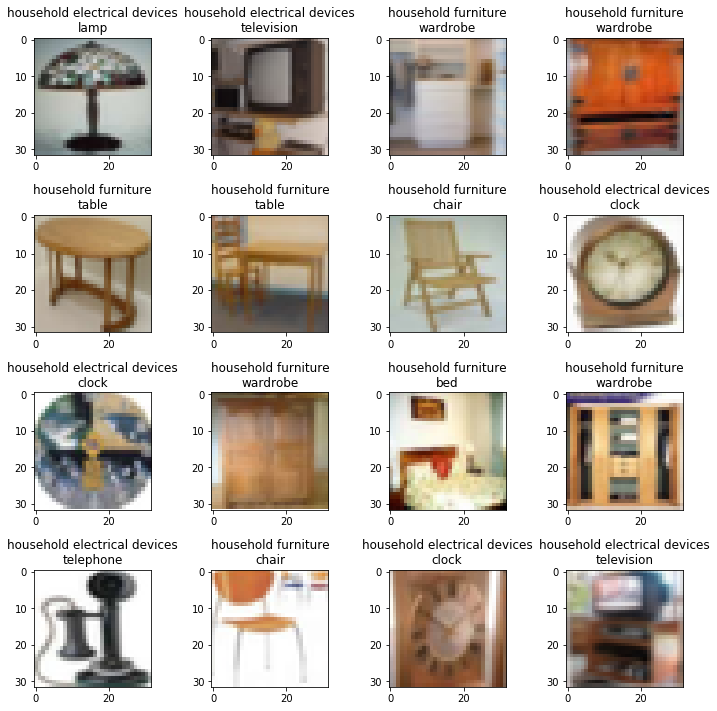

In [27]:
indices = [np.random.choice(range(len(X_cifar100_hh))) for i in range(16)]

cifar_grid(X_cifar100_hh,Y_cifar100_hh,indices,4)

In [28]:
import pandas as pd

type(y_test)
y_train_1 = Y_cifar100_hh.ravel()

pd.Series(y_train_1).value_counts().sort_index()

0    600
1    600
2    600
3    600
4    600
5    600
6    600
7    600
8    600
9    600
dtype: int64

In [0]:
dict = {0 : 0, 1 : 0, 2 : 0 , 3 : 0, 4 : 0, 5: 1, 6 : 1, 7 : 1, 8 : 1, 9 : 1}
data_household_cifar100_binary = data_household_cifar100['Target'].map( dict )


In [0]:
data_household_cifar100_binary = data_household_cifar100_binary.to_frame()

In [31]:
data_household_cifar100_binary.columns = ['Target_binary']
data_household_cifar100_binary.head()

,Target_binary
0,0
1,0
2,0
3,0
4,1


In [0]:
data_household_cifar100_binary =pd.concat([data_household_cifar100, data_household_cifar100_binary], axis=1)

In [33]:
X_cifar100_bin_hh = data_household_cifar100_binary.drop(['Target','Target_binary'], axis = 1).as_matrix()
Y_cifar100_bin_hh = np.array(data_household_cifar100_binary['Target_binary'].values.reshape(-1,1).tolist())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


## Prediction with Feedforward Neural Networks

In [0]:
#Let's review how MLPClassifier got trained and do prediction
from datetime import datetime
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split


X_cifar100_bin_hh_train, X_cifar100_bin_hh_test, Y_cifar100_bin_hh_train, Y_cifar100_bin_hh_test = train_test_split(X_cifar100_bin_hh,Y_cifar100_bin_hh,
                                                                                                                    test_size=0.2)



In [0]:
#Normalize data
X_cifar100_bin_hh_train = X_cifar100_bin_hh_train.astype('float32')
X_cifar100_bin_hh_train /= 255.0

X_cifar100_bin_hh_test = X_cifar100_bin_hh_test.astype('float32')
X_cifar100_bin_hh_test /= 255.0

In [36]:
#Let's review how MLPClassifier got trained and do prediction

t1 = datetime.now()
mlp = MLPClassifier(hidden_layer_sizes=(100), activation='relu', random_state=68)
mlp.fit(X_cifar100_bin_hh_train, Y_cifar100_bin_hh_train)
print("time taken =", datetime.now()-t1)
score =mlp.score(X_cifar100_bin_hh_test, Y_cifar100_bin_hh_test)
print('MLP NN score: %.2f%%' %(score*100))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


time taken = 0:02:01.569707
MLP NN score: 70.67%


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Prediction with XGBoost

In [37]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
t1 = datetime.now()
model_xgb = XGBClassifier()
model_xgb.fit(X_cifar100_bin_hh_train, Y_cifar100_bin_hh_train)
print("time taken =", datetime.now()-t1)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


time taken = 0:00:58.936491


In [38]:
print(model_xgb)
# make predictions for test data
y_pred_xgb = model_xgb.predict(X_cifar100_bin_hh_test)
predictions = [round(value) for value in y_pred_xgb]

accuracy = accuracy_score(Y_cifar100_bin_hh_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Accuracy: 74.33%


## Prediction with RandomForest

In [40]:
#Let's see how good is RandomForest
from sklearn.ensemble import RandomForestClassifier
t1 = datetime.now()
logit_rfc = RandomForestClassifier()
logit_rfc.fit(X_cifar100_bin_hh_train, Y_cifar100_bin_hh_train)
print("time taken =", datetime.now()-t1)
print ("RandomForest Accuracy: {}%".format(logit_rfc.score(X_cifar100_bin_hh_test, Y_cifar100_bin_hh_test)*100))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


time taken = 0:00:01.912441
RandomForest Accuracy: 70.91666666666666%


In [0]:
t1 = datetime.now()
mlp = MLPClassifier(hidden_layer_sizes=(6155), activation='relu', random_state=68)
mlp.fit(X_cifar100_bin_hh_train, Y_cifar100_bin_hh_train)
print("time taken =", datetime.now()-t1)
score =mlp.score(X_cifar100_bin_hh_test, Y_cifar100_bin_hh_test)
print('MLP NN score: %.2f%%' %(score*100))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


time taken = 0:48:25.689095
MLP NN score: 68.25%


In [0]:
predicted = mlp.predict(X_cifar100_bin_hh_test)

In [0]:
type(X_cifar100_bin_hh_train)

numpy.ndarray

## Image identification with CNN

In [0]:
X_cifar100_CNN = X_cifar100_bin_hh_train.reshape(X_cifar100_bin_hh_train.shape[0],3,32,32).transpose([0,2, 3, 1])

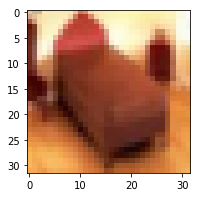

In [0]:
fig = plt.figure(figsize=(3, 3))
# fig.add_subplot(10,10)
plt.imshow(X_cifar100_CNN[900], interpolation='nearest')

In [0]:
X_cifar100_CNN.shape[1:]

(32, 32, 3)

In [0]:
model = Sequential()

model.add(Conv2D(50, kernel_size=(3, 3), activation='relu', input_shape=X_cifar100_CNN.shape[1:]))
# model.add(Conv2D(48, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(1))

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(96, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


opt = Adam(lr=0.00005, decay=1e-6)

model.compile(loss='binay_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

ValueError: ignored

In [0]:
#Let's train the model
epochs = 30
hist = model.fit_generator(datagen.flow(x_train, y_train_c,
    batch_size=batch_size,shuffle=True),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test_c),
    workers=4)

In [0]:
scores = model.evaluate(x_test, y_test_c, verbose=0)
print("CNN score: %.2f%%" % (scores[1]*100))

In [0]:
#print out randomly selected images(black/red labl-->correct/wrong prediction )
def cifar_grid_c(X,Y,inds,n_col, predictions=None):
  if predictions is not None:
    if Y.shape != predictions.shape:
      print("Predictions must equal Y in length!")
      return(None)
  N = len(inds)
  n_row = int(ceil(1.0*N/n_col))
  fig, axes = plt.subplots(n_row,n_col,figsize=(10,10))
  
#  clabels = labels["label_names"]
  clabels = ['household electrical devices','household furniture']
  print(type(clabels))
  for j in range(n_row):
    for k in range(n_col):
      i_inds = (j*n_col)+k
      i_data = inds[i_inds]
      
     # axes[j][k].set_axis_off()
      if i_inds < N:
        rgb = X[[i_data,...]]
        img = rgb.reshape(3,32,32).transpose([1, 2, 0])
        axes[j][k].imshow(img, interpolation='nearest')
        label =clabels[Y[i_data][0]]
        axes[j][k].set_title(label)
        if predictions is not None:
          pred = clabels[predictions[i_data][0]]
          print(pred, label)
          if label != pred:
            print('Hi')
            label += " n"
            axes[j][k].set_title(pred, color='red')            
  
  fig.set_tight_layout(True)

<class 'list'>
household electrical devices household electrical devices
household furniture household furniture
household electrical devices household electrical devices
household electrical devices household furniture
Hi
household electrical devices household furniture
Hi
household electrical devices household furniture
Hi
household furniture household furniture
household electrical devices household electrical devices
household furniture household electrical devices
Hi
household furniture household furniture
household electrical devices household electrical devices
household electrical devices household electrical devices
household electrical devices household furniture
Hi
household electrical devices household furniture
Hi
household furniture household furniture
household furniture household electrical devices
Hi


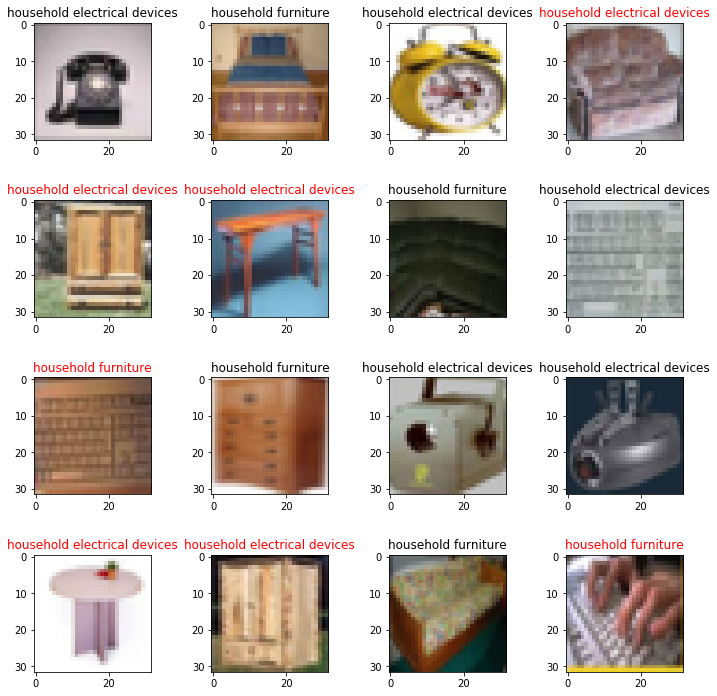

In [0]:
import warnings
warnings.filterwarnings("ignore")

num_predictions = 16
predict_gen = mlp.predict(X_test_hh)
predict_gen = np.array(predict_gen.reshape(-1,1).tolist())
indices = [np.random.choice(range(len(X_test_hh))) 
           for i in range(num_predictions)]
cifar_grid_c(X_test_hh,Y_test_hh,indices,4, predictions=predict_gen)

In [0]:
from datetime import datetime
t1 = datetime.now()
print("Hello")
print("time taken =", datetime.now()-t1)

Hello
time taken = 0:00:00.000433


In [0]:
Y_test_hh.shape

(1000,)

In [0]:
predict_gen.shape

(1000,)

In [0]:
# rgb = X_train_hh[[208,...]]
print(type(X_train_hh))

<class 'numpy.ndarray'>


In [0]:
print(type(X_test_hh))

<class 'pandas.core.frame.DataFrame'>
